In [1]:
import numpy as np
import torch

# initialize the RNG deterministically
np.random.seed(42)
torch.manual_seed(42)
torch.set_float32_matmul_precision('medium')

In [2]:
# parameters
dataset_name = "QPM_species"
model_name = "flow_mse"
ood = "1"

In [3]:
# Parameters
ood = 4


In [4]:
# initialize data attributes and loaders
from config import load_config

config = load_config(
    dataset_name = dataset_name,
    model_name = model_name,
    ood = ood,
)
config.load_data()
config.print_labels()
dm = config.datamodule

assert dm

In [5]:
dm.setup("fit")
dm.setup("test")
dm.setup("predict")

Dataset type train label type: species


Loaded 344518 images
Dataset type val label type: species


Loaded 44696 images
Dataset type test label type: species


Loaded 44924 images
Dataset type train label type: species


Loaded 30925 images
Dataset type val label type: species


Loaded 3866 images
Dataset type test label type: species


Loaded 3866 images


In [6]:
# model id for each ood_k
model_ids = ['3qdutcy1', 'czgx4bod', '72y7x1fk', 'cqp59iho', 'fwur6c78']
model_id = model_ids[config.ood[0]]
print(model_id)

fwur6c78


In [7]:
model = config.get_model()

In [8]:
from pathlib import Path
from lightning.pytorch.loggers.wandb import WandbLogger

artifact_dir = WandbLogger.download_artifact(artifact=f"yasith/robust_ml/model-{model_id}:best")
model = model.__class__.load_from_checkpoint(Path(artifact_dir) / "model.ckpt", config=config)
model = model.cuda()
model.eval();

wandb:   1 of 1 files downloaded.  


In [9]:
train_loader = dm.train_dataloader()
val_loader = dm.val_dataloader()
test_loader = dm.test_dataloader()
predict_loader = dm.predict_dataloader()

In [10]:
from models.common import edl_probs
from tqdm import tqdm

ind_targets = []
ood_targets = []

ind_u_norms = []
ood_u_norms = []
rnd_u_norms = []

ind_v_norms = []
ood_v_norms = []
rnd_v_norms = []

# test set (ind)
for batch_idx, batch in enumerate(tqdm(test_loader)):
    x, y, *_ = batch
    x = x.float().cuda()
    v, z, x_m, u_norm, v_norm, logits = model(x)
    ind_u_norms.extend(u_norm.detach().cpu().numpy())
    ind_v_norms.extend(v_norm.detach().cpu().numpy())
    ind_targets.extend(y.detach().cpu().numpy())
print("test InD - OK")

# predict set (ood)
for batch_idx, batch in enumerate(tqdm(predict_loader)):
    x, y, *_ = batch
    x = x.float().cuda()
    v, z, x_m, u_norm, v_norm, logits = model(x)
    ood_u_norms.extend(u_norm.detach().cpu().numpy())
    ood_v_norms.extend(v_norm.detach().cpu().numpy())
    ood_targets.extend(y.detach().cpu().numpy())
print("test OoD - OK")

# random set
rnd_set = torch.randn(100, config.batch_size, *config.input_shape)
for batch_idx, batch in enumerate(tqdm(rnd_set)):
    x = batch
    x = x.float().cuda()
    v, z, x_m, u_norm, v_norm, logits = model(x)
    rnd_u_norms.extend(u_norm.detach().cpu().numpy())
    rnd_v_norms.extend(v_norm.detach().cpu().numpy())
print("test RnD - OK")

ind_targets = np.array(ind_targets).squeeze()
ood_targets = np.array(ood_targets).squeeze()
    
ind_u_norms = np.array(ind_u_norms).squeeze()
ood_u_norms = np.array(ood_u_norms).squeeze()
rnd_u_norms = np.array(rnd_u_norms).squeeze()

ind_v_norms = np.array(ind_v_norms).squeeze()
ood_v_norms = np.array(ood_v_norms).squeeze()
rnd_v_norms = np.array(rnd_v_norms).squeeze()

print(ind_u_norms.shape, ind_v_norms.shape)
print(ood_u_norms.shape, ood_v_norms.shape)
print(rnd_u_norms.shape, rnd_v_norms.shape)

  0%|                                                                                                                                                                  | 0/351 [00:00<?, ?it/s]

  0%|▍                                                                                                                                                         | 1/351 [00:01<07:48,  1.34s/it]

  1%|▉                                                                                                                                                         | 2/351 [00:01<03:35,  1.62it/s]

  1%|█▊                                                                                                                                                        | 4/351 [00:01<01:40,  3.47it/s]

  2%|██▋                                                                                                                                                       | 6/351 [00:01<01:07,  5.15it/s]

  2%|███▌                                                                                                                                                      | 8/351 [00:01<00:52,  6.59it/s]

  3%|████▎                                                                                                                                                    | 10/351 [00:02<00:44,  7.74it/s]

  3%|█████▏                                                                                                                                                   | 12/351 [00:02<00:39,  8.67it/s]

  4%|██████                                                                                                                                                   | 14/351 [00:02<00:35,  9.39it/s]

  5%|██████▉                                                                                                                                                  | 16/351 [00:02<00:33,  9.92it/s]

  5%|███████▊                                                                                                                                                 | 18/351 [00:02<00:32, 10.31it/s]

  6%|████████▋                                                                                                                                                | 20/351 [00:03<00:31, 10.58it/s]

  6%|█████████▌                                                                                                                                               | 22/351 [00:03<00:30, 10.77it/s]

  7%|██████████▍                                                                                                                                              | 24/351 [00:03<00:29, 10.91it/s]

  7%|███████████▎                                                                                                                                             | 26/351 [00:03<00:29, 11.01it/s]

  8%|████████████▏                                                                                                                                            | 28/351 [00:03<00:29, 11.08it/s]

  9%|█████████████                                                                                                                                            | 30/351 [00:03<00:28, 11.11it/s]

  9%|█████████████▉                                                                                                                                           | 32/351 [00:04<00:28, 11.16it/s]

 10%|██████████████▊                                                                                                                                          | 34/351 [00:04<00:28, 11.19it/s]

 10%|███████████████▋                                                                                                                                         | 36/351 [00:04<00:28, 11.20it/s]

 11%|████████████████▌                                                                                                                                        | 38/351 [00:04<00:27, 11.21it/s]

 11%|█████████████████▍                                                                                                                                       | 40/351 [00:04<00:27, 11.23it/s]

 12%|██████████████████▎                                                                                                                                      | 42/351 [00:05<00:27, 11.24it/s]

 13%|███████████████████▏                                                                                                                                     | 44/351 [00:05<00:27, 11.24it/s]

 13%|████████████████████                                                                                                                                     | 46/351 [00:05<00:27, 11.24it/s]

 14%|████████████████████▉                                                                                                                                    | 48/351 [00:05<00:26, 11.25it/s]

 14%|█████████████████████▊                                                                                                                                   | 50/351 [00:05<00:26, 11.24it/s]

 15%|██████████████████████▋                                                                                                                                  | 52/351 [00:05<00:26, 11.25it/s]

 15%|███████████████████████▌                                                                                                                                 | 54/351 [00:06<00:26, 11.25it/s]

 16%|████████████████████████▍                                                                                                                                | 56/351 [00:06<00:26, 11.25it/s]

 17%|█████████████████████████▎                                                                                                                               | 58/351 [00:06<00:26, 11.26it/s]

 17%|██████████████████████████▏                                                                                                                              | 60/351 [00:06<00:25, 11.26it/s]

 18%|███████████████████████████                                                                                                                              | 62/351 [00:06<00:25, 11.26it/s]

 18%|███████████████████████████▉                                                                                                                             | 64/351 [00:06<00:25, 11.24it/s]

 19%|████████████████████████████▊                                                                                                                            | 66/351 [00:07<00:25, 11.24it/s]

 19%|█████████████████████████████▋                                                                                                                           | 68/351 [00:07<00:25, 11.25it/s]

 20%|██████████████████████████████▌                                                                                                                          | 70/351 [00:07<00:24, 11.25it/s]

 21%|███████████████████████████████▍                                                                                                                         | 72/351 [00:07<00:24, 11.22it/s]

 21%|████████████████████████████████▎                                                                                                                        | 74/351 [00:07<00:24, 11.24it/s]

 22%|█████████████████████████████████▏                                                                                                                       | 76/351 [00:08<00:24, 11.24it/s]

 22%|██████████████████████████████████                                                                                                                       | 78/351 [00:08<00:24, 11.24it/s]

 23%|██████████████████████████████████▊                                                                                                                      | 80/351 [00:08<00:24, 11.24it/s]

 23%|███████████████████████████████████▋                                                                                                                     | 82/351 [00:08<00:23, 11.23it/s]

 24%|████████████████████████████████████▌                                                                                                                    | 84/351 [00:08<00:23, 11.23it/s]

 25%|█████████████████████████████████████▍                                                                                                                   | 86/351 [00:08<00:23, 11.23it/s]

 25%|██████████████████████████████████████▎                                                                                                                  | 88/351 [00:09<00:23, 11.23it/s]

 26%|███████████████████████████████████████▏                                                                                                                 | 90/351 [00:09<00:23, 11.24it/s]

 26%|████████████████████████████████████████                                                                                                                 | 92/351 [00:09<00:23, 11.24it/s]

 27%|████████████████████████████████████████▉                                                                                                                | 94/351 [00:09<00:22, 11.23it/s]

 27%|█████████████████████████████████████████▊                                                                                                               | 96/351 [00:09<00:22, 11.23it/s]

 28%|██████████████████████████████████████████▋                                                                                                              | 98/351 [00:09<00:22, 11.24it/s]

 28%|███████████████████████████████████████████▎                                                                                                            | 100/351 [00:10<00:22, 11.23it/s]

 29%|████████████████████████████████████████████▏                                                                                                           | 102/351 [00:10<00:22, 11.23it/s]

 30%|█████████████████████████████████████████████                                                                                                           | 104/351 [00:10<00:22, 11.22it/s]

 30%|█████████████████████████████████████████████▉                                                                                                          | 106/351 [00:10<00:21, 11.23it/s]

 31%|██████████████████████████████████████████████▊                                                                                                         | 108/351 [00:10<00:21, 11.23it/s]

 31%|███████████████████████████████████████████████▋                                                                                                        | 110/351 [00:11<00:21, 11.24it/s]

 32%|████████████████████████████████████████████████▌                                                                                                       | 112/351 [00:11<00:21, 11.25it/s]

 32%|█████████████████████████████████████████████████▎                                                                                                      | 114/351 [00:11<00:21, 11.25it/s]

 33%|██████████████████████████████████████████████████▏                                                                                                     | 116/351 [00:11<00:20, 11.25it/s]

 34%|███████████████████████████████████████████████████                                                                                                     | 118/351 [00:11<00:20, 11.24it/s]

 34%|███████████████████████████████████████████████████▉                                                                                                    | 120/351 [00:11<00:20, 11.23it/s]

 35%|████████████████████████████████████████████████████▊                                                                                                   | 122/351 [00:12<00:20, 11.23it/s]

 35%|█████████████████████████████████████████████████████▋                                                                                                  | 124/351 [00:12<00:20, 11.23it/s]

 36%|██████████████████████████████████████████████████████▌                                                                                                 | 126/351 [00:12<00:20, 11.23it/s]

 36%|███████████████████████████████████████████████████████▍                                                                                                | 128/351 [00:12<00:19, 11.24it/s]

 37%|████████████████████████████████████████████████████████▎                                                                                               | 130/351 [00:12<00:19, 11.24it/s]

 38%|█████████████████████████████████████████████████████████▏                                                                                              | 132/351 [00:13<00:19, 11.23it/s]

 38%|██████████████████████████████████████████████████████████                                                                                              | 134/351 [00:13<00:19, 11.23it/s]

 39%|██████████████████████████████████████████████████████████▉                                                                                             | 136/351 [00:13<00:19, 11.23it/s]

 39%|███████████████████████████████████████████████████████████▊                                                                                            | 138/351 [00:13<00:18, 11.22it/s]

 40%|████████████████████████████████████████████████████████████▋                                                                                           | 140/351 [00:13<00:18, 11.23it/s]

 40%|█████████████████████████████████████████████████████████████▍                                                                                          | 142/351 [00:13<00:18, 11.19it/s]

 41%|██████████████████████████████████████████████████████████████▎                                                                                         | 144/351 [00:14<00:18, 11.20it/s]

 42%|███████████████████████████████████████████████████████████████▏                                                                                        | 146/351 [00:14<00:18, 11.20it/s]

 42%|████████████████████████████████████████████████████████████████                                                                                        | 148/351 [00:14<00:18, 11.21it/s]

 43%|████████████████████████████████████████████████████████████████▉                                                                                       | 150/351 [00:14<00:17, 11.22it/s]

 43%|█████████████████████████████████████████████████████████████████▊                                                                                      | 152/351 [00:14<00:17, 11.24it/s]

 44%|██████████████████████████████████████████████████████████████████▋                                                                                     | 154/351 [00:14<00:17, 11.23it/s]

 44%|███████████████████████████████████████████████████████████████████▌                                                                                    | 156/351 [00:15<00:17, 11.24it/s]

 45%|████████████████████████████████████████████████████████████████████▍                                                                                   | 158/351 [00:15<00:17, 11.24it/s]

 46%|█████████████████████████████████████████████████████████████████████▎                                                                                  | 160/351 [00:15<00:16, 11.24it/s]

 46%|██████████████████████████████████████████████████████████████████████▏                                                                                 | 162/351 [00:15<00:16, 11.24it/s]

 47%|███████████████████████████████████████████████████████████████████████                                                                                 | 164/351 [00:15<00:16, 11.24it/s]

 47%|███████████████████████████████████████████████████████████████████████▉                                                                                | 166/351 [00:16<00:16, 11.24it/s]

 48%|████████████████████████████████████████████████████████████████████████▊                                                                               | 168/351 [00:16<00:16, 11.25it/s]

 48%|█████████████████████████████████████████████████████████████████████████▌                                                                              | 170/351 [00:16<00:16, 11.24it/s]

 49%|██████████████████████████████████████████████████████████████████████████▍                                                                             | 172/351 [00:16<00:15, 11.24it/s]

 50%|███████████████████████████████████████████████████████████████████████████▎                                                                            | 174/351 [00:16<00:15, 11.23it/s]

 50%|████████████████████████████████████████████████████████████████████████████▏                                                                           | 176/351 [00:16<00:15, 11.21it/s]

 51%|█████████████████████████████████████████████████████████████████████████████                                                                           | 178/351 [00:17<00:15, 11.22it/s]

 51%|█████████████████████████████████████████████████████████████████████████████▉                                                                          | 180/351 [00:17<00:15, 11.23it/s]

 52%|██████████████████████████████████████████████████████████████████████████████▊                                                                         | 182/351 [00:17<00:15, 11.23it/s]

 52%|███████████████████████████████████████████████████████████████████████████████▋                                                                        | 184/351 [00:17<00:14, 11.24it/s]

 53%|████████████████████████████████████████████████████████████████████████████████▌                                                                       | 186/351 [00:17<00:14, 11.23it/s]

 54%|█████████████████████████████████████████████████████████████████████████████████▍                                                                      | 188/351 [00:18<00:14, 11.24it/s]

 54%|██████████████████████████████████████████████████████████████████████████████████▎                                                                     | 190/351 [00:18<00:14, 11.24it/s]

 55%|███████████████████████████████████████████████████████████████████████████████████▏                                                                    | 192/351 [00:18<00:14, 11.23it/s]

 55%|████████████████████████████████████████████████████████████████████████████████████                                                                    | 194/351 [00:18<00:13, 11.23it/s]

 56%|████████████████████████████████████████████████████████████████████████████████████▉                                                                   | 196/351 [00:18<00:13, 11.23it/s]

 56%|█████████████████████████████████████████████████████████████████████████████████████▋                                                                  | 198/351 [00:18<00:13, 11.21it/s]

 57%|██████████████████████████████████████████████████████████████████████████████████████▌                                                                 | 200/351 [00:19<00:13, 11.22it/s]

 58%|███████████████████████████████████████████████████████████████████████████████████████▍                                                                | 202/351 [00:19<00:13, 11.22it/s]

 58%|████████████████████████████████████████████████████████████████████████████████████████▎                                                               | 204/351 [00:19<00:13, 11.22it/s]

 59%|█████████████████████████████████████████████████████████████████████████████████████████▏                                                              | 206/351 [00:19<00:12, 11.22it/s]

 59%|██████████████████████████████████████████████████████████████████████████████████████████                                                              | 208/351 [00:19<00:12, 11.22it/s]

 60%|██████████████████████████████████████████████████████████████████████████████████████████▉                                                             | 210/351 [00:19<00:12, 11.23it/s]

 60%|███████████████████████████████████████████████████████████████████████████████████████████▊                                                            | 212/351 [00:20<00:12, 11.24it/s]

 61%|████████████████████████████████████████████████████████████████████████████████████████████▋                                                           | 214/351 [00:20<00:12, 11.24it/s]

 62%|█████████████████████████████████████████████████████████████████████████████████████████████▌                                                          | 216/351 [00:20<00:12, 11.22it/s]

 62%|██████████████████████████████████████████████████████████████████████████████████████████████▍                                                         | 218/351 [00:20<00:11, 11.23it/s]

 63%|███████████████████████████████████████████████████████████████████████████████████████████████▎                                                        | 220/351 [00:20<00:11, 11.22it/s]

 63%|████████████████████████████████████████████████████████████████████████████████████████████████▏                                                       | 222/351 [00:21<00:11, 11.21it/s]

 64%|█████████████████████████████████████████████████████████████████████████████████████████████████                                                       | 224/351 [00:21<00:11, 11.22it/s]

 64%|█████████████████████████████████████████████████████████████████████████████████████████████████▊                                                      | 226/351 [00:21<00:11, 11.19it/s]

 65%|██████████████████████████████████████████████████████████████████████████████████████████████████▋                                                     | 228/351 [00:21<00:10, 11.20it/s]

 66%|███████████████████████████████████████████████████████████████████████████████████████████████████▌                                                    | 230/351 [00:21<00:10, 11.21it/s]

 66%|████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                   | 232/351 [00:21<00:10, 11.21it/s]

 67%|█████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                  | 234/351 [00:22<00:10, 11.22it/s]

 67%|██████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                 | 236/351 [00:22<00:10, 11.22it/s]

 68%|███████████████████████████████████████████████████████████████████████████████████████████████████████                                                 | 238/351 [00:22<00:10, 11.22it/s]

 68%|███████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                | 240/351 [00:22<00:09, 11.22it/s]

 69%|████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                               | 242/351 [00:22<00:09, 11.22it/s]

 70%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                              | 244/351 [00:23<00:09, 11.21it/s]

 70%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                             | 246/351 [00:23<00:09, 11.21it/s]

 71%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                            | 248/351 [00:23<00:09, 11.21it/s]

 71%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                           | 250/351 [00:23<00:09, 11.20it/s]

 72%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                          | 252/351 [00:23<00:08, 11.20it/s]

 72%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                          | 254/351 [00:23<00:08, 11.19it/s]

 73%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                         | 256/351 [00:24<00:08, 11.20it/s]

 74%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                        | 258/351 [00:24<00:08, 11.20it/s]

 74%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                       | 260/351 [00:24<00:08, 11.20it/s]

 75%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                      | 262/351 [00:24<00:07, 11.20it/s]

 75%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                     | 264/351 [00:24<00:07, 11.20it/s]

 76%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                    | 266/351 [00:24<00:07, 11.21it/s]

 76%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                    | 268/351 [00:25<00:07, 11.21it/s]

 77%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                   | 270/351 [00:25<00:07, 11.20it/s]

 77%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                  | 272/351 [00:25<00:07, 11.19it/s]

 78%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                 | 274/351 [00:25<00:06, 11.20it/s]

 79%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                | 276/351 [00:25<00:06, 11.20it/s]

 79%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                               | 278/351 [00:26<00:06, 11.20it/s]

 80%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                              | 280/351 [00:26<00:06, 11.20it/s]

 80%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                              | 282/351 [00:26<00:06, 11.18it/s]

 81%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                             | 284/351 [00:26<00:05, 11.19it/s]

 81%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                            | 286/351 [00:26<00:05, 11.19it/s]

 82%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                           | 288/351 [00:26<00:05, 11.19it/s]

 83%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                          | 290/351 [00:27<00:05, 11.20it/s]

 83%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                         | 292/351 [00:27<00:05, 11.20it/s]

 84%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                        | 294/351 [00:27<00:05, 11.20it/s]

 84%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                       | 296/351 [00:27<00:04, 11.20it/s]

 85%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                       | 298/351 [00:27<00:04, 11.20it/s]

 85%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                      | 300/351 [00:28<00:04, 11.20it/s]

 86%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                     | 302/351 [00:28<00:04, 11.21it/s]

 87%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                    | 304/351 [00:28<00:04, 11.21it/s]

 87%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                   | 306/351 [00:28<00:04, 11.21it/s]

 88%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                  | 308/351 [00:28<00:03, 11.21it/s]

 88%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                 | 310/351 [00:28<00:03, 11.21it/s]

 89%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                 | 312/351 [00:29<00:03, 11.20it/s]

 89%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                | 314/351 [00:29<00:03, 11.21it/s]

 90%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊               | 316/351 [00:29<00:03, 11.20it/s]

 91%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋              | 318/351 [00:29<00:02, 11.19it/s]

 91%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌             | 320/351 [00:29<00:02, 11.20it/s]

 92%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍            | 322/351 [00:29<00:02, 11.20it/s]

 92%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎           | 324/351 [00:30<00:02, 11.20it/s]

 93%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏          | 326/351 [00:30<00:02, 11.20it/s]

 93%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████          | 328/351 [00:30<00:02, 11.20it/s]

 94%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉         | 330/351 [00:30<00:01, 11.20it/s]

 95%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊        | 332/351 [00:30<00:01, 11.19it/s]

 95%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋       | 334/351 [00:31<00:01, 11.20it/s]

 96%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌      | 336/351 [00:31<00:01, 11.21it/s]

 96%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎     | 338/351 [00:31<00:01, 11.21it/s]

 97%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏    | 340/351 [00:31<00:00, 11.21it/s]

 97%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████    | 342/351 [00:31<00:00, 11.21it/s]

 98%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉   | 344/351 [00:31<00:00, 11.22it/s]

 99%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊  | 346/351 [00:32<00:00, 11.25it/s]

 99%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋ | 348/351 [00:32<00:00, 11.28it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌| 350/351 [00:32<00:00, 11.30it/s]

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 351/351 [00:32<00:00, 10.77it/s]

test InD - OK


  0%|                                                                                                                                                                  | 0/303 [00:00<?, ?it/s]

  0%|▌                                                                                                                                                         | 1/303 [00:00<01:14,  4.04it/s]

  1%|█▌                                                                                                                                                        | 3/303 [00:00<00:39,  7.57it/s]

  2%|██▌                                                                                                                                                       | 5/303 [00:00<00:32,  9.08it/s]

  2%|███▌                                                                                                                                                      | 7/303 [00:00<00:29,  9.87it/s]

  3%|████▌                                                                                                                                                     | 9/303 [00:00<00:28, 10.34it/s]

  4%|█████▌                                                                                                                                                   | 11/303 [00:01<00:27, 10.63it/s]

  4%|██████▌                                                                                                                                                  | 13/303 [00:01<00:26, 10.82it/s]

  5%|███████▌                                                                                                                                                 | 15/303 [00:01<00:26, 10.94it/s]

  6%|████████▌                                                                                                                                                | 17/303 [00:01<00:25, 11.02it/s]

  6%|█████████▌                                                                                                                                               | 19/303 [00:01<00:25, 11.07it/s]

  7%|██████████▌                                                                                                                                              | 21/303 [00:02<00:25, 11.11it/s]

  8%|███████████▌                                                                                                                                             | 23/303 [00:02<00:25, 11.14it/s]

  8%|████████████▌                                                                                                                                            | 25/303 [00:02<00:24, 11.15it/s]

  9%|█████████████▋                                                                                                                                           | 27/303 [00:02<00:24, 11.17it/s]

 10%|██████████████▋                                                                                                                                          | 29/303 [00:02<00:24, 11.18it/s]

 10%|███████████████▋                                                                                                                                         | 31/303 [00:02<00:24, 11.20it/s]

 11%|████████████████▋                                                                                                                                        | 33/303 [00:03<00:24, 11.19it/s]

 12%|█████████████████▋                                                                                                                                       | 35/303 [00:03<00:23, 11.20it/s]

 12%|██████████████████▋                                                                                                                                      | 37/303 [00:03<00:23, 11.20it/s]

 13%|███████████████████▋                                                                                                                                     | 39/303 [00:03<00:23, 11.21it/s]

 14%|████████████████████▋                                                                                                                                    | 41/303 [00:03<00:23, 11.21it/s]

 14%|█████████████████████▋                                                                                                                                   | 43/303 [00:04<00:23, 11.20it/s]

 15%|██████████████████████▋                                                                                                                                  | 45/303 [00:04<00:23, 11.20it/s]

 16%|███████████████████████▋                                                                                                                                 | 47/303 [00:04<00:22, 11.20it/s]

 16%|████████████████████████▋                                                                                                                                | 49/303 [00:04<00:22, 11.20it/s]

 17%|█████████████████████████▊                                                                                                                               | 51/303 [00:04<00:22, 11.21it/s]

 17%|██████████████████████████▊                                                                                                                              | 53/303 [00:04<00:22, 11.21it/s]

 18%|███████████████████████████▊                                                                                                                             | 55/303 [00:05<00:22, 11.21it/s]

 19%|████████████████████████████▊                                                                                                                            | 57/303 [00:05<00:21, 11.21it/s]

 19%|█████████████████████████████▊                                                                                                                           | 59/303 [00:05<00:21, 11.21it/s]

 20%|██████████████████████████████▊                                                                                                                          | 61/303 [00:05<00:21, 11.22it/s]

 21%|███████████████████████████████▊                                                                                                                         | 63/303 [00:05<00:21, 11.22it/s]

 21%|████████████████████████████████▊                                                                                                                        | 65/303 [00:05<00:21, 11.21it/s]

 22%|█████████████████████████████████▊                                                                                                                       | 67/303 [00:06<00:21, 11.20it/s]

 23%|██████████████████████████████████▊                                                                                                                      | 69/303 [00:06<00:20, 11.20it/s]

 23%|███████████████████████████████████▊                                                                                                                     | 71/303 [00:06<00:20, 11.21it/s]

 24%|████████████████████████████████████▊                                                                                                                    | 73/303 [00:06<00:20, 11.21it/s]

 25%|█████████████████████████████████████▊                                                                                                                   | 75/303 [00:06<00:20, 11.21it/s]

 25%|██████████████████████████████████████▉                                                                                                                  | 77/303 [00:07<00:20, 11.21it/s]

 26%|███████████████████████████████████████▉                                                                                                                 | 79/303 [00:07<00:19, 11.21it/s]

 27%|████████████████████████████████████████▉                                                                                                                | 81/303 [00:07<00:19, 11.22it/s]

 27%|█████████████████████████████████████████▉                                                                                                               | 83/303 [00:07<00:19, 11.20it/s]

 28%|██████████████████████████████████████████▉                                                                                                              | 85/303 [00:07<00:19, 11.21it/s]

 29%|███████████████████████████████████████████▉                                                                                                             | 87/303 [00:07<00:19, 11.21it/s]

 29%|████████████████████████████████████████████▉                                                                                                            | 89/303 [00:08<00:19, 11.21it/s]

 30%|█████████████████████████████████████████████▉                                                                                                           | 91/303 [00:08<00:18, 11.21it/s]

 31%|██████████████████████████████████████████████▉                                                                                                          | 93/303 [00:08<00:18, 11.21it/s]

 31%|███████████████████████████████████████████████▉                                                                                                         | 95/303 [00:08<00:18, 11.21it/s]

 32%|████████████████████████████████████████████████▉                                                                                                        | 97/303 [00:08<00:18, 11.21it/s]

 33%|█████████████████████████████████████████████████▉                                                                                                       | 99/303 [00:08<00:18, 11.21it/s]

 33%|██████████████████████████████████████████████████▋                                                                                                     | 101/303 [00:09<00:18, 11.21it/s]

 34%|███████████████████████████████████████████████████▋                                                                                                    | 103/303 [00:09<00:17, 11.21it/s]

 35%|████████████████████████████████████████████████████▋                                                                                                   | 105/303 [00:09<00:17, 11.21it/s]

 35%|█████████████████████████████████████████████████████▋                                                                                                  | 107/303 [00:09<00:17, 11.21it/s]

 36%|██████████████████████████████████████████████████████▋                                                                                                 | 109/303 [00:09<00:17, 11.21it/s]

 37%|███████████████████████████████████████████████████████▋                                                                                                | 111/303 [00:10<00:17, 11.20it/s]

 37%|████████████████████████████████████████████████████████▋                                                                                               | 113/303 [00:10<00:16, 11.21it/s]

 38%|█████████████████████████████████████████████████████████▋                                                                                              | 115/303 [00:10<00:16, 11.21it/s]

 39%|██████████████████████████████████████████████████████████▋                                                                                             | 117/303 [00:10<00:16, 11.21it/s]

 39%|███████████████████████████████████████████████████████████▋                                                                                            | 119/303 [00:10<00:16, 11.21it/s]

 40%|████████████████████████████████████████████████████████████▋                                                                                           | 121/303 [00:10<00:16, 11.20it/s]

 41%|█████████████████████████████████████████████████████████████▋                                                                                          | 123/303 [00:11<00:16, 11.21it/s]

 41%|██████████████████████████████████████████████████████████████▋                                                                                         | 125/303 [00:11<00:15, 11.21it/s]

 42%|███████████████████████████████████████████████████████████████▋                                                                                        | 127/303 [00:11<00:15, 11.20it/s]

 43%|████████████████████████████████████████████████████████████████▋                                                                                       | 129/303 [00:11<00:15, 11.20it/s]

 43%|█████████████████████████████████████████████████████████████████▋                                                                                      | 131/303 [00:11<00:15, 11.20it/s]

 44%|██████████████████████████████████████████████████████████████████▋                                                                                     | 133/303 [00:12<00:15, 11.20it/s]

 45%|███████████████████████████████████████████████████████████████████▋                                                                                    | 135/303 [00:12<00:14, 11.21it/s]

 45%|████████████████████████████████████████████████████████████████████▋                                                                                   | 137/303 [00:12<00:14, 11.20it/s]

 46%|█████████████████████████████████████████████████████████████████████▋                                                                                  | 139/303 [00:12<00:14, 11.20it/s]

 47%|██████████████████████████████████████████████████████████████████████▋                                                                                 | 141/303 [00:12<00:14, 11.20it/s]

 47%|███████████████████████████████████████████████████████████████████████▋                                                                                | 143/303 [00:12<00:14, 11.20it/s]

 48%|████████████████████████████████████████████████████████████████████████▋                                                                               | 145/303 [00:13<00:14, 11.20it/s]

 49%|█████████████████████████████████████████████████████████████████████████▋                                                                              | 147/303 [00:13<00:13, 11.20it/s]

 49%|██████████████████████████████████████████████████████████████████████████▋                                                                             | 149/303 [00:13<00:13, 11.20it/s]

 50%|███████████████████████████████████████████████████████████████████████████▋                                                                            | 151/303 [00:13<00:13, 11.20it/s]

 50%|████████████████████████████████████████████████████████████████████████████▊                                                                           | 153/303 [00:13<00:13, 11.20it/s]

 51%|█████████████████████████████████████████████████████████████████████████████▊                                                                          | 155/303 [00:13<00:13, 11.20it/s]

 52%|██████████████████████████████████████████████████████████████████████████████▊                                                                         | 157/303 [00:14<00:13, 11.18it/s]

 52%|███████████████████████████████████████████████████████████████████████████████▊                                                                        | 159/303 [00:14<00:12, 11.18it/s]

 53%|████████████████████████████████████████████████████████████████████████████████▊                                                                       | 161/303 [00:14<00:12, 11.19it/s]

 54%|█████████████████████████████████████████████████████████████████████████████████▊                                                                      | 163/303 [00:14<00:12, 11.20it/s]

 54%|██████████████████████████████████████████████████████████████████████████████████▊                                                                     | 165/303 [00:14<00:12, 11.20it/s]

 55%|███████████████████████████████████████████████████████████████████████████████████▊                                                                    | 167/303 [00:15<00:12, 11.20it/s]

 56%|████████████████████████████████████████████████████████████████████████████████████▊                                                                   | 169/303 [00:15<00:11, 11.20it/s]

 56%|█████████████████████████████████████████████████████████████████████████████████████▊                                                                  | 171/303 [00:15<00:11, 11.20it/s]

 57%|██████████████████████████████████████████████████████████████████████████████████████▊                                                                 | 173/303 [00:15<00:11, 11.20it/s]

 58%|███████████████████████████████████████████████████████████████████████████████████████▊                                                                | 175/303 [00:15<00:11, 11.20it/s]

 58%|████████████████████████████████████████████████████████████████████████████████████████▊                                                               | 177/303 [00:15<00:11, 11.20it/s]

 59%|█████████████████████████████████████████████████████████████████████████████████████████▊                                                              | 179/303 [00:16<00:11, 11.20it/s]

 60%|██████████████████████████████████████████████████████████████████████████████████████████▊                                                             | 181/303 [00:16<00:10, 11.20it/s]

 60%|███████████████████████████████████████████████████████████████████████████████████████████▊                                                            | 183/303 [00:16<00:10, 11.21it/s]

 61%|████████████████████████████████████████████████████████████████████████████████████████████▊                                                           | 185/303 [00:16<00:10, 11.20it/s]

 62%|█████████████████████████████████████████████████████████████████████████████████████████████▊                                                          | 187/303 [00:16<00:10, 11.20it/s]

 62%|██████████████████████████████████████████████████████████████████████████████████████████████▊                                                         | 189/303 [00:17<00:10, 11.20it/s]

 63%|███████████████████████████████████████████████████████████████████████████████████████████████▊                                                        | 191/303 [00:17<00:09, 11.20it/s]

 64%|████████████████████████████████████████████████████████████████████████████████████████████████▊                                                       | 193/303 [00:17<00:09, 11.20it/s]

 64%|█████████████████████████████████████████████████████████████████████████████████████████████████▊                                                      | 195/303 [00:17<00:09, 11.20it/s]

 65%|██████████████████████████████████████████████████████████████████████████████████████████████████▊                                                     | 197/303 [00:17<00:09, 11.19it/s]

 66%|███████████████████████████████████████████████████████████████████████████████████████████████████▊                                                    | 199/303 [00:17<00:09, 11.20it/s]

 66%|████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                   | 201/303 [00:18<00:09, 11.21it/s]

 67%|█████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                  | 203/303 [00:18<00:08, 11.20it/s]

 68%|██████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                 | 205/303 [00:18<00:08, 11.21it/s]

 68%|███████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                | 207/303 [00:18<00:08, 11.20it/s]

 69%|████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                               | 209/303 [00:18<00:08, 11.20it/s]

 70%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                              | 211/303 [00:18<00:08, 11.20it/s]

 70%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                             | 213/303 [00:19<00:08, 11.20it/s]

 71%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                            | 215/303 [00:19<00:07, 11.20it/s]

 72%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                           | 217/303 [00:19<00:07, 11.20it/s]

 72%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                          | 219/303 [00:19<00:07, 11.20it/s]

 73%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                         | 221/303 [00:19<00:07, 11.18it/s]

 74%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                        | 223/303 [00:20<00:07, 11.19it/s]

 74%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                       | 225/303 [00:20<00:06, 11.19it/s]

 75%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                      | 227/303 [00:20<00:06, 11.19it/s]

 76%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                     | 229/303 [00:20<00:06, 11.19it/s]

 76%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                    | 231/303 [00:20<00:06, 11.20it/s]

 77%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                   | 233/303 [00:20<00:06, 11.19it/s]

 78%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                  | 235/303 [00:21<00:06, 11.20it/s]

 78%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                 | 237/303 [00:21<00:05, 11.20it/s]

 79%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                | 239/303 [00:21<00:05, 11.20it/s]

 80%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                               | 241/303 [00:21<00:05, 11.20it/s]

 80%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                              | 243/303 [00:21<00:05, 11.20it/s]

 81%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                             | 245/303 [00:22<00:05, 11.20it/s]

 82%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                            | 247/303 [00:22<00:05, 11.20it/s]

 82%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                           | 249/303 [00:22<00:04, 11.19it/s]

 83%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                          | 251/303 [00:22<00:04, 11.20it/s]

 83%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                         | 253/303 [00:22<00:04, 11.20it/s]

 84%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                        | 255/303 [00:22<00:04, 11.19it/s]

 85%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                       | 257/303 [00:23<00:04, 11.19it/s]

 85%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                      | 259/303 [00:23<00:03, 11.19it/s]

 86%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                     | 261/303 [00:23<00:03, 11.19it/s]

 87%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                    | 263/303 [00:23<00:03, 11.19it/s]

 87%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                   | 265/303 [00:23<00:03, 11.19it/s]

 88%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                  | 267/303 [00:23<00:03, 11.19it/s]

 89%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                 | 269/303 [00:24<00:03, 11.19it/s]

 89%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                | 271/303 [00:24<00:02, 11.20it/s]

 90%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉               | 273/303 [00:24<00:02, 11.20it/s]

 91%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉              | 275/303 [00:24<00:02, 11.20it/s]

 91%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉             | 277/303 [00:24<00:02, 11.20it/s]

 92%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉            | 279/303 [00:25<00:02, 11.19it/s]

 93%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉           | 281/303 [00:25<00:01, 11.18it/s]

 93%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉          | 283/303 [00:25<00:01, 11.18it/s]

 94%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉         | 285/303 [00:25<00:01, 11.18it/s]

 95%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉        | 287/303 [00:25<00:01, 11.19it/s]

 95%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉       | 289/303 [00:25<00:01, 11.19it/s]

 96%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉      | 291/303 [00:26<00:01, 11.20it/s]

 97%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉     | 293/303 [00:26<00:00, 11.20it/s]

 97%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉    | 295/303 [00:26<00:00, 11.20it/s]

 98%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉   | 297/303 [00:26<00:00, 11.23it/s]

 99%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉  | 299/303 [00:26<00:00, 11.26it/s]

 99%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉ | 301/303 [00:27<00:00, 11.29it/s]

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 303/303 [00:27<00:00, 12.20it/s]

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 303/303 [00:27<00:00, 11.14it/s]

test OoD - OK


  0%|                                                                                                                                                                  | 0/100 [00:00<?, ?it/s]

  2%|███                                                                                                                                                       | 2/100 [00:00<00:08, 11.26it/s]

  4%|██████▏                                                                                                                                                   | 4/100 [00:00<00:08, 11.34it/s]

  6%|█████████▏                                                                                                                                                | 6/100 [00:00<00:08, 11.38it/s]

  8%|████████████▎                                                                                                                                             | 8/100 [00:00<00:08, 11.40it/s]

 10%|███████████████▎                                                                                                                                         | 10/100 [00:00<00:07, 11.42it/s]

 12%|██████████████████▎                                                                                                                                      | 12/100 [00:01<00:07, 11.42it/s]

 14%|█████████████████████▍                                                                                                                                   | 14/100 [00:01<00:07, 11.42it/s]

 16%|████████████████████████▍                                                                                                                                | 16/100 [00:01<00:07, 11.43it/s]

 18%|███████████████████████████▌                                                                                                                             | 18/100 [00:01<00:07, 11.44it/s]

 20%|██████████████████████████████▌                                                                                                                          | 20/100 [00:01<00:06, 11.44it/s]

 22%|█████████████████████████████████▋                                                                                                                       | 22/100 [00:01<00:06, 11.43it/s]

 24%|████████████████████████████████████▋                                                                                                                    | 24/100 [00:02<00:06, 11.44it/s]

 26%|███████████████████████████████████████▊                                                                                                                 | 26/100 [00:02<00:06, 11.44it/s]

 28%|██████████████████████████████████████████▊                                                                                                              | 28/100 [00:02<00:06, 11.44it/s]

 30%|█████████████████████████████████████████████▉                                                                                                           | 30/100 [00:02<00:06, 11.44it/s]

 32%|████████████████████████████████████████████████▉                                                                                                        | 32/100 [00:02<00:05, 11.44it/s]

 34%|████████████████████████████████████████████████████                                                                                                     | 34/100 [00:02<00:05, 11.45it/s]

 36%|███████████████████████████████████████████████████████                                                                                                  | 36/100 [00:03<00:05, 11.45it/s]

 38%|██████████████████████████████████████████████████████████▏                                                                                              | 38/100 [00:03<00:05, 11.44it/s]

 40%|█████████████████████████████████████████████████████████████▏                                                                                           | 40/100 [00:03<00:05, 11.44it/s]

 42%|████████████████████████████████████████████████████████████████▎                                                                                        | 42/100 [00:03<00:05, 11.44it/s]

 44%|███████████████████████████████████████████████████████████████████▎                                                                                     | 44/100 [00:03<00:04, 11.44it/s]

 46%|██████████████████████████████████████████████████████████████████████▍                                                                                  | 46/100 [00:04<00:04, 11.45it/s]

 48%|█████████████████████████████████████████████████████████████████████████▍                                                                               | 48/100 [00:04<00:04, 11.44it/s]

 50%|████████████████████████████████████████████████████████████████████████████▌                                                                            | 50/100 [00:04<00:04, 11.44it/s]

 52%|███████████████████████████████████████████████████████████████████████████████▌                                                                         | 52/100 [00:04<00:04, 11.44it/s]

 54%|██████████████████████████████████████████████████████████████████████████████████▌                                                                      | 54/100 [00:04<00:04, 11.44it/s]

 56%|█████████████████████████████████████████████████████████████████████████████████████▋                                                                   | 56/100 [00:04<00:03, 11.44it/s]

 58%|████████████████████████████████████████████████████████████████████████████████████████▋                                                                | 58/100 [00:05<00:03, 11.45it/s]

 60%|███████████████████████████████████████████████████████████████████████████████████████████▊                                                             | 60/100 [00:05<00:03, 11.44it/s]

 62%|██████████████████████████████████████████████████████████████████████████████████████████████▊                                                          | 62/100 [00:05<00:03, 11.45it/s]

 64%|█████████████████████████████████████████████████████████████████████████████████████████████████▉                                                       | 64/100 [00:05<00:03, 11.44it/s]

 66%|████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                    | 66/100 [00:05<00:02, 11.45it/s]

 68%|████████████████████████████████████████████████████████████████████████████████████████████████████████                                                 | 68/100 [00:05<00:02, 11.44it/s]

 70%|███████████████████████████████████████████████████████████████████████████████████████████████████████████                                              | 70/100 [00:06<00:02, 11.44it/s]

 72%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                          | 72/100 [00:06<00:02, 11.44it/s]

 74%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                       | 74/100 [00:06<00:02, 11.44it/s]

 76%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                    | 76/100 [00:06<00:02, 11.44it/s]

 78%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                 | 78/100 [00:06<00:01, 11.44it/s]

 80%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                              | 80/100 [00:06<00:01, 11.44it/s]

 82%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                           | 82/100 [00:07<00:01, 11.44it/s]

 84%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                        | 84/100 [00:07<00:01, 11.45it/s]

 86%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                     | 86/100 [00:07<00:01, 11.45it/s]

 88%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                  | 88/100 [00:07<00:01, 11.45it/s]

 90%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋               | 90/100 [00:07<00:00, 11.44it/s]

 92%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊            | 92/100 [00:08<00:00, 11.44it/s]

 94%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊         | 94/100 [00:08<00:00, 11.44it/s]

 96%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉      | 96/100 [00:08<00:00, 11.44it/s]

 98%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉   | 98/100 [00:08<00:00, 11.44it/s]

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:08<00:00, 11.44it/s]

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:08<00:00, 11.43it/s]

test RnD - OK
(44924,) (44924,)
(38657,) (38657,)
(12800,) (12800,)


In [11]:
ind_u_norms_scaled = np.tanh(ind_u_norms)
ood_u_norms_scaled = np.tanh(ood_u_norms)
rnd_u_norms_scaled = np.tanh(rnd_u_norms)
ind_v_norms_scaled = np.tanh(ind_v_norms)
ood_v_norms_scaled = np.tanh(ood_v_norms)
rnd_v_norms_scaled = np.tanh(rnd_v_norms)

print(ind_u_norms.mean(), ind_u_norms.std())
print(ood_u_norms.mean(), ood_u_norms.std())
print(rnd_u_norms.mean(), rnd_u_norms.std())
print(ind_v_norms.mean(), ind_v_norms.std())
print(ood_v_norms.mean(), ood_v_norms.std())
print(rnd_v_norms.mean(), rnd_v_norms.std())

3.192475 0.023858115
3.1517653 0.014182273
5.385225 0.25044057
0.004757025 0.001905942
0.00413352 0.011519099
10.991053 0.3488194


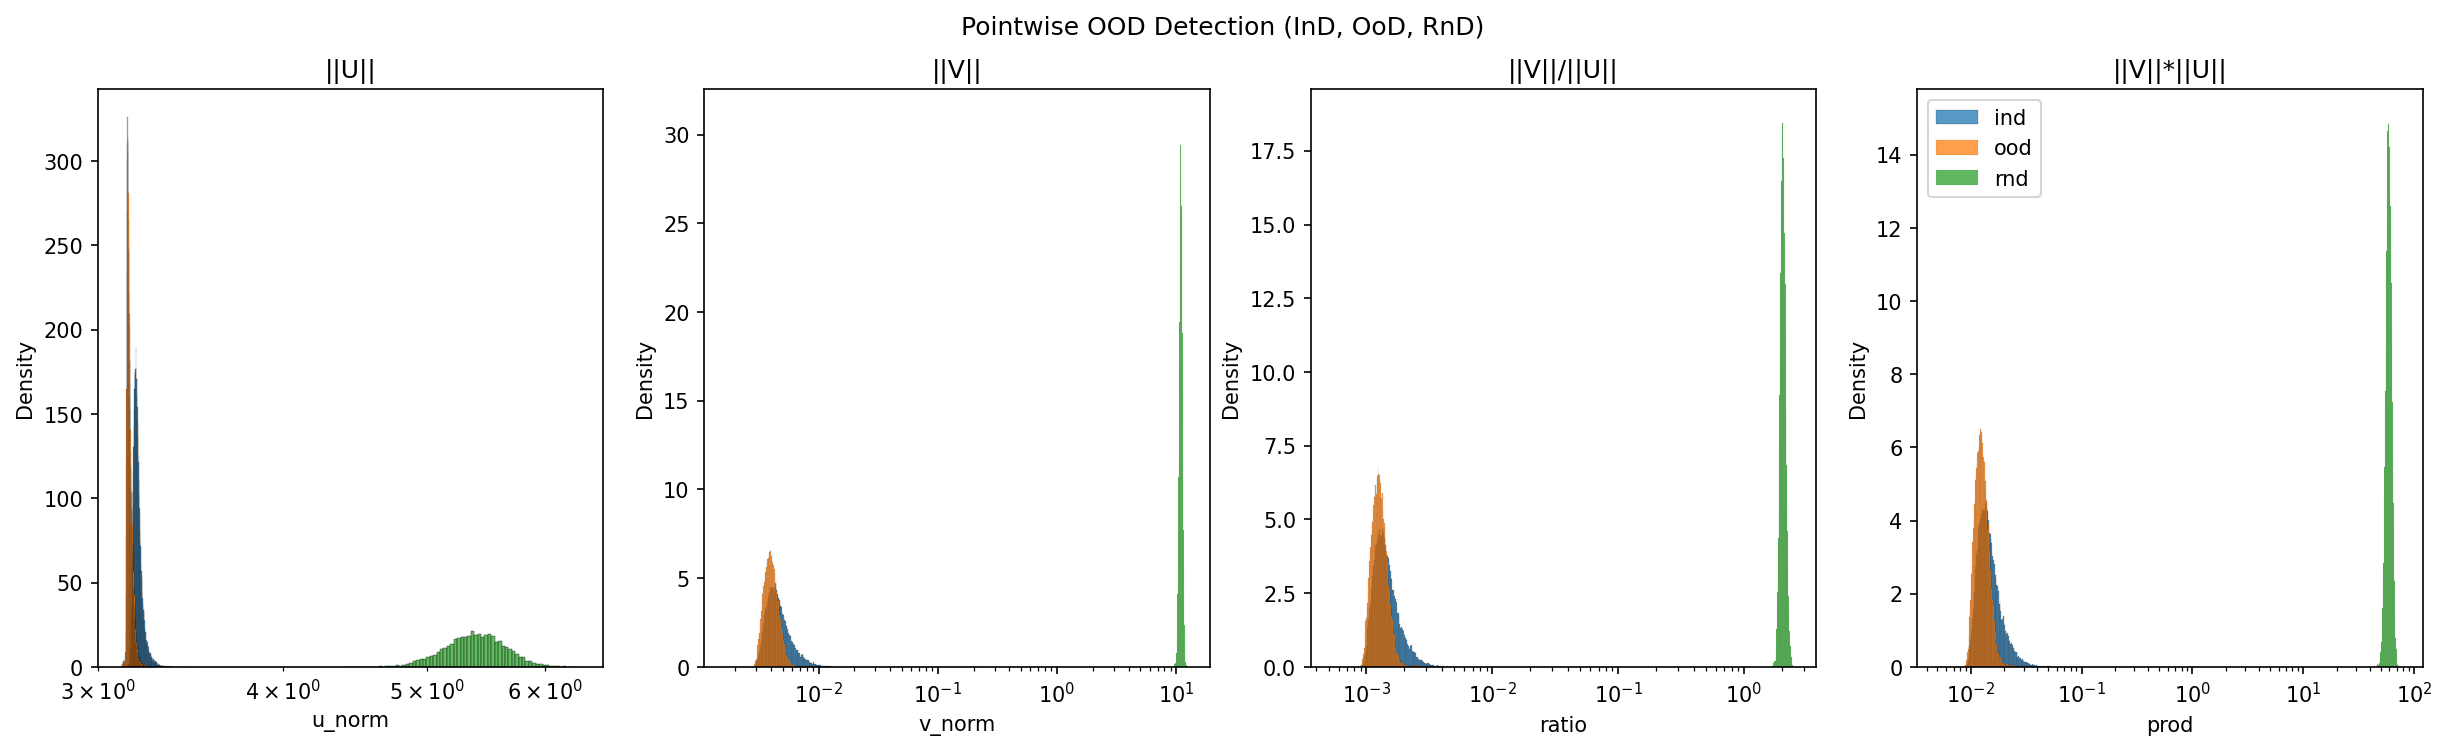

In [12]:
from matplotlib import pyplot as plt
import seaborn as sns
import pandas as pd

plt.rcParams['figure.figsize'] = (5, 5)
plt.rcParams['figure.dpi'] = 150

data_ind = pd.DataFrame(dict(u_norm=ind_u_norms, v_norm=ind_v_norms, ratio=ind_v_norms/ind_u_norms, prod=ind_v_norms*ind_u_norms, target=ind_targets))
data_ood = pd.DataFrame(dict(u_norm=ood_u_norms, v_norm=ood_v_norms, ratio=ood_v_norms/ood_u_norms, prod=ood_v_norms*ood_u_norms, target=ood_targets))
data_rnd = pd.DataFrame(dict(u_norm=rnd_u_norms, v_norm=rnd_v_norms, ratio=rnd_v_norms/rnd_u_norms, prod=rnd_v_norms*rnd_u_norms))

fig, (ax1, ax2, ax3, ax4) = plt.subplots(1, 4, figsize = (20, 5))
fig.suptitle("Pointwise OOD Detection (InD, OoD, RnD)")

sns.histplot(data=data_ind, x="u_norm", log_scale=True, fill=True, label='ind', stat='density', ax=ax1)
sns.histplot(data=data_ood, x="u_norm", log_scale=True, fill=True, label='ood', stat='density', ax=ax1)
sns.histplot(data=data_rnd, x="u_norm", log_scale=True, fill=True, label='rnd', stat='density', ax=ax1)

sns.histplot(data=data_ind, x="v_norm", log_scale=True, fill=True, label='ind', stat='density', ax=ax2)
sns.histplot(data=data_ood, x="v_norm", log_scale=True, fill=True, label='ood', stat='density', ax=ax2)
sns.histplot(data=data_rnd, x="v_norm", log_scale=True, fill=True, label='rnd', stat='density', ax=ax2)

sns.histplot(data=data_ind, x="ratio", log_scale=True, fill=True, label='ind', stat='density', ax=ax3)
sns.histplot(data=data_ood, x="ratio", log_scale=True, fill=True, label='ood', stat='density', ax=ax3)
sns.histplot(data=data_rnd, x="ratio", log_scale=True, fill=True, label='rnd', stat='density', ax=ax3)

sns.histplot(data=data_ind, x="prod", log_scale=True, fill=True, label='ind', stat='density', ax=ax4)
sns.histplot(data=data_ood, x="prod", log_scale=True, fill=True, label='ood', stat='density', ax=ax4)
sns.histplot(data=data_rnd, x="prod", log_scale=True, fill=True, label='rnd', stat='density', ax=ax4)

ax1.title.set_text('||U||')
ax2.title.set_text('||V||')
ax3.title.set_text('||V||/||U||')
ax4.title.set_text('||V||*||U||')

plt.legend()
plt.show()

In [13]:
from scipy import stats
print("Ind", ind_v_norms.min(), ind_v_norms.max(), ind_v_norms.ptp())
print("Ood", ood_v_norms.min(), ood_v_norms.max(), ood_v_norms.ptp())
print("Rnd", rnd_v_norms.min(), rnd_v_norms.max(), rnd_v_norms.ptp())

ks_ind_ood = stats.kstest(ind_v_norms, ood_v_norms)
print(ks_ind_ood)

Ind 0.0017069677 0.25243923 0.25073227
Ood 0.0017069677 1.6128045 1.6110976
Rnd 9.702419 12.286517 2.5840979
KstestResult(statistic=0.2684828127992762, pvalue=0.0, statistic_location=0.004439802, statistic_sign=-1)


[0 1 2 3 4]


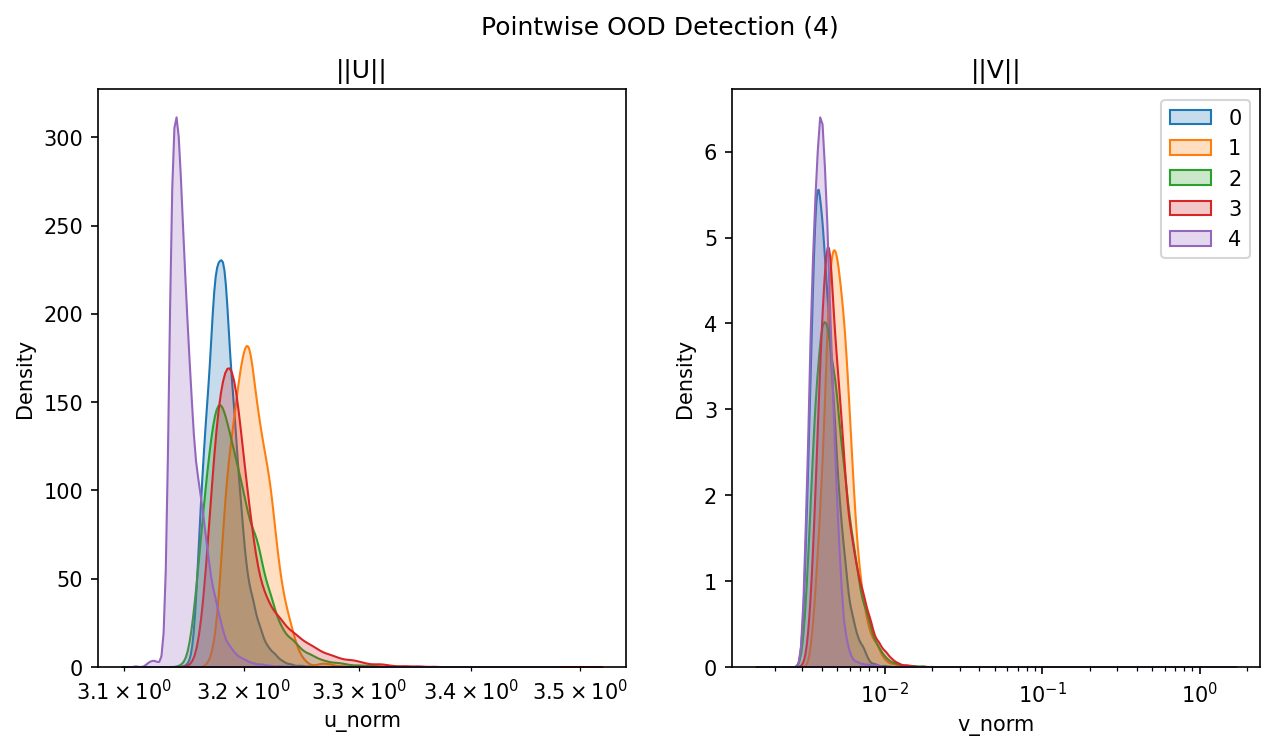

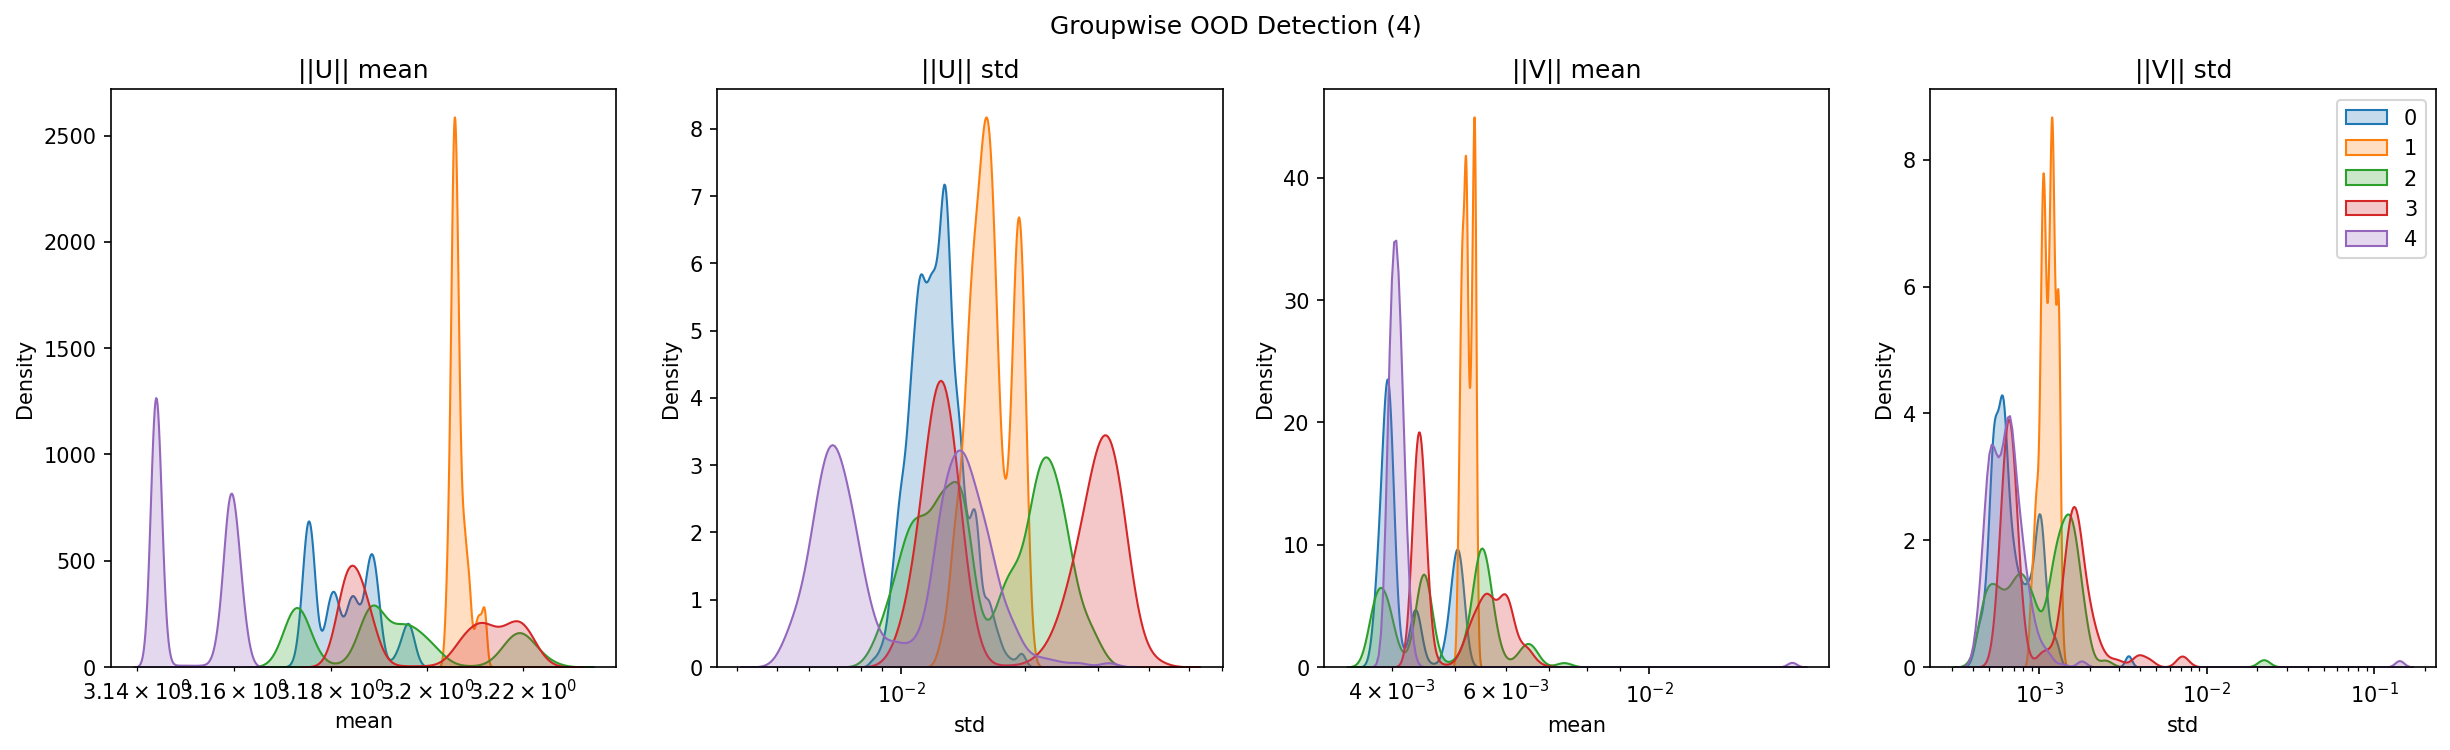

In [14]:
df = pd.concat([data_ind, data_ood], axis=0)
print(df['target'].unique())

N = 128

pointwise = {}
groupwise = {}

for i in range(5):
    df_slice = df[df['target'] == i]
    pointwise[i] = df_slice.copy()
    d = df_slice.rolling(N).agg(['mean', 'std']).dropna()
    groupwise[i] = d.copy()

# pointwise
fig, (ax1, ax2) = plt.subplots(1, 2, figsize = (10, 5))
fig.suptitle(f"Pointwise OOD Detection ({':'.join(map(str,config.ood))})")

for i in range(5):
    data = pointwise[i]
    i = str(i)
    sns.kdeplot(data=data, x="u_norm", log_scale=True, fill=True, label=i, ax=ax1)
    sns.kdeplot(data=data, x="v_norm", log_scale=True, fill=True, label=i, ax=ax2)

ax1.title.set_text('||U||')
ax2.title.set_text('||V||')
plt.legend()
plt.show()

    
# groupwise
fig, (ax1, ax2, ax3, ax4) = plt.subplots(1, 4, figsize = (20, 5))
fig.suptitle(f"Groupwise OOD Detection ({':'.join(map(str,config.ood))})")

for i in range(5):
    data = groupwise[i]
    i = str(i)
    sns.kdeplot(data=data.u_norm, x="mean", log_scale=True, fill=True, label=i, ax=ax1)
    sns.kdeplot(data=data.u_norm, x="std", log_scale=True, fill=True, label=i, ax=ax2)
    sns.kdeplot(data=data.v_norm, x="mean", log_scale=True, fill=True, label=i, ax=ax3)
    sns.kdeplot(data=data.v_norm, x="std", log_scale=True, fill=True, label=i, ax=ax4)

ax1.title.set_text('||U|| mean')
ax2.title.set_text('||U|| std')
ax3.title.set_text('||V|| mean')
ax4.title.set_text('||V|| std')
plt.legend()
plt.show()